# Основы машинного обучения (ИАД)
## НИУ ВШЭ, 2021-2022 учебный год

### Домашнее задание №8

In [2]:
import numpy as np
import pandas as pd
import sklearn
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, mean_squared_error

# Бустинг

## Градиентный бустинг своими руками (3 + 2* баллов)

Реализуйте алгоритм градиентного бустинга для регрессии. Напомним **основные формулы**.

Обозначим текущую композицию на $N-1$ шаге за $a_{N - 1}(x_i)$. Следующий базовый алгоритм $b_N(x_i)$ обучается на ответах $-\frac{\partial L(y_i, z)}{\partial z}\Bigl|_{z = a_{N - 1}(x_i)}$, где $L(y_i, z)$ — значение функции потерь на объекте при правильном ответе $y_i$ и предсказании $z$. Композиция на следующем шаге получается следующим образом:

$$
a_N(x_i) = a_{N-1}(x_i) + \nu\gamma_Nb_N(x_i)
$$

Здесь $\nu$ — гиперпараметр learning rate, $\gamma_N$ — оптимальный вес, настраиваемый на каждом шаге алгоритма, который можно найти по следующей формуле (обратите внимание на отсутствие $\nu$):

$$
\gamma_N = \mathrm{arg}\min_\gamma \frac{1}{\ell}\sum\limits_{i=1}^{\ell}L\left(y_i, a_{N - 1}(x_i) + \gamma b_N(x_i)\right)
$$

Можете принять $\gamma_N = 1$ для каждого $N$.

> Реализуйте нахождение оптимального $\gamma_N$ на каждом шаге, чтобы получить ещё 1 балл.


В качестве функции потерь возьмите **MSE**.

*Примечание. Вы можете использовать `DecisionTree` из `sklearn` и методы оптимизации из различных библиотек.*

In [3]:
# это может помочь вам для поиска оптимальных gamma
from scipy.optimize import minimize

In [4]:
class GradientBoosting:
    def __init__(self, n_estimators, max_depth, learning_rate=0.1):
        """
        PARAMETERS:
        n_estimators - number of trees in the ensemble
        max_depth - maximum depth of a tree
        learning_rate - coefficient by which new algorithm result is multiplied
        """
        # your code here
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.learning_rate = learning_rate
        self.trees = []
        self.aN = 0
        self.gamma = 0.5
        self.gammas = []
        
        self.tree = DecisionTreeClassifier(max_depth=self.max_depth)

    def MSE(self, prediction:np.array, y:np.array):
        expression = (y - prediction)**2
        return expression.mean()
    
    def L(self, gamma, x, y):
        loss = 0
        expression = self.aN + gamma* self.tree.predict(x)
        
        for index in range(len(y)):
            loss += self.MSE(expression[index], y[index])
            
        return loss/len(y)
    
    def fit(self, x, y):
        """
        INPUT:
        x - np.array of shape (k, d)
        y - np.array of shape (k,)
        """
        # Здесь нам нужно проитерироваться по n_estimators и обучить
        # соответствующее количество деревьев с помощью _fit_predict_tree(),
        # правильно обновляя y_new
        # Деревья нужно где-то сохранить, чтобы затем использовать в predict()
        # your code here
        
        self.a0 = y.mean()
        self.aN = self.a0
        for iteration in range(self.n_estimators):
            s_i = y - self.aN
            self.aN += self._fit_predict_tree(x, s_i, y)
        
            
    def _fit_predict_tree(self, x, s_i, y):
        # Обучаем дерево и возвращаем его предикшн
        
        self.tree = DecisionTreeRegressor(max_depth=self.max_depth)
        self.tree.fit(x,s_i)
        self.trees.append(self.tree)
        
        self.gamma = minimize(self.L,  args=(x, y), x0=1).x
        self.gammas.append(self.gamma)
        return self.gamma * self.learning_rate * self.tree.predict(x)
        
    def predict(self, x):
        """
        INPUT:
        x - np.array of shape (m, d)
        OUTPUT:
        y_pred - np.array of shape (m,)
        """
        # Используем сохранённые деревья для расчёта агрегированного предикшна
        # your code here
        
        y_pred = self.a0
        for iteration in range(len(self.trees)):
            y_pred += self.learning_rate*self.trees[iteration].predict(x)*self.gammas[iteration]
        return y_pred

Проверьте вашу реализацию на Boston dataset. 

> Подберите оптимальные гиперпараметры, чтобы победить RandomForestRegressor как в обычном случае, так и при нахождении оптимального шага **(не меняйте параметры сида)**. При необходимости воспользуйтесь GridSearch. За это вы получите ещё 1 балл.



In [5]:
boston = load_boston()
X = boston.data
y = boston.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=13)

C:\Users\nikita\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset 

In [6]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(max_features=4, n_estimators=640, random_state=19052019)

rf.fit(X_train, y_train)
mean_squared_error(y_test, rf.predict(X_test))

9.63198271791959

In [7]:
np.random.seed(19052019)

# your code here

GB = GradientBoosting(n_estimators=50, max_depth=8, learning_rate=0.334)
GB.fit(X_train, y_train)
y_pred = GB.predict(X_test)

In [8]:
mean_squared_error(y_test, y_pred)

9.139781586163519

Для удобства проверяющего укажите, пожалуйста, реализовали ли вы нахождение оптимального шага?

- $\underline {Да}$ / Нет

## Прогнозируем задержки самолётов (2 балла)

Поработаем с задачей про задержки самолётов. На основании доступных данных о рейсе вам нужно определить, будет ли он задержан на 15 минут.
Воспользуйтесь любыми методами градиентного бустинга {`XGboost`, `catboost`, `LightGBM`} и `GridSearchCV` для достижения результата.

> Получите 1 балл за преодоление порога roc_auc_score 0.72 и ещё 1 балл за преодоление порога 0.74.



In [9]:
train = pd.read_csv('https://raw.githubusercontent.com/PersDep/data-mining-intro-2021/main/hw08-boosting-clustering-data/flight_delays_train.csv')
test = pd.read_csv('https://raw.githubusercontent.com/PersDep/data-mining-intro-2021/main/hw08-boosting-clustering-data/flight_delays_test.csv')

In [10]:
train.head()

Month DayofMonth DayOfWeek  DepTime UniqueCarrier Origin Dest  Distance  \
0   c-8       c-21       c-7     1934            AA    ATL  DFW       732   
1   c-4       c-20       c-3     1548            US    PIT  MCO       834   
2   c-9        c-2       c-5     1422            XE    RDU  CLE       416   
3  c-11       c-25       c-6     1015            OO    DEN  MEM       872   
4  c-10        c-7       c-6     1828            WN    MDW  OMA       423   

  dep_delayed_15min  
0                 N  
1                 N  
2                 N  
3                 N  
4                 Y

In [11]:
# Референс
from xgboost.sklearn import XGBClassifier

X_train = train[['Distance', 'DepTime']].values
y_train = train['dep_delayed_15min'].map({'Y': 1, 'N': 0}).values
X_test = test[['Distance', 'DepTime']].values
X_train_part, X_valid, y_train_part, y_valid = train_test_split(X_train, y_train, test_size=0.3)

xgb_model = XGBClassifier()
xgb_model.fit(X_train_part, y_train_part)
roc_auc_score(y_valid, xgb_model.predict_proba(X_valid)[:, 1])

0.701794300059084

In [12]:
encoder = sklearn.preprocessing.LabelEncoder()
encoder.fit(train['Month'].drop_duplicates()) 
train['Month'] = encoder.transform(train['Month'])

encoder.fit(train['DayofMonth'].drop_duplicates())
train['DayofMonth'] = encoder.transform(train['DayofMonth'])

encoder.fit(train['DayOfWeek'].drop_duplicates())
train['DayOfWeek'] = encoder.transform(train['DayOfWeek'])

train['dep_delayed_15min'] = train['dep_delayed_15min'].map({'Y':1, 'N':0})

encoder.fit(train['Origin'].drop_duplicates())
train['Origin'] = encoder.transform(train['Origin'])

encoder.fit(train['Dest'].drop_duplicates())
train['Dest'] = encoder.transform(train['Dest'])

encoder.fit(train['UniqueCarrier'].drop_duplicates())
train['UniqueCarrier'] = encoder.transform(train['UniqueCarrier'])

train

Month  DayofMonth  DayOfWeek  DepTime  UniqueCarrier  Origin  Dest  \
0         10          13          6     1934              0      18    78   
1          6          12          2     1548             18     217   171   
2         11          11          4     1422             20     228    59   
3          2          17          5     1015             15      78   175   
4          1          28          5     1828             19     174   199   
...      ...         ...        ...      ...            ...     ...   ...   
99995      7          25          2     1618             15     246   224   
99996      0           9          2      804              4      92    72   
99997      0          16          1     1901             13      85   131   
99998      6          19          3     1515             12      79   107   
99999      2           8          3     1800             19     245   253   

       Distance  dep_delayed_15min  
0           732                  0  
1           834                  0  
2           416                  0  
3           872                  0  
4           423                  1  
...         ...                ...  
99995       199                  0  
99996       884                  0  
99997      1076                  0  
99998       140                  0  
99999       605                  0  

[100000 rows x 9 columns]

In [13]:
X_train = train[['Distance', 'DepTime', 'DayofMonth', 'DayOfWeek', 'Month', 'UniqueCarrier', 'Origin', 'Dest']].values
y_train = train['dep_delayed_15min'].values

X_train_part, X_valid, y_train_part, y_valid = train_test_split(X_train, y_train, test_size=0.3, random_state = 2002)

In [14]:
# your code here
from sklearn.ensemble import GradientBoostingClassifier

second_try = GradientBoostingClassifier(max_depth=7, n_estimators = 250, learning_rate = 0.095)
second_try.fit(X_train_part, y_train_part)

y_predicted = second_try.predict_proba(X_valid)[:, 1]

In [15]:
roc_auc_score(y_valid, y_predicted)

0.7412369736844224

# Кластеризация

## DBSCAN своими руками (3 + 2* баллов)


```
DBSCAN: Density-based spatial clustering of applications with noise
```


Реализуйте класс dbscan.

Алгоритм имеет два основных гиперпараметра:
1. `eps` &mdash; радиус рассматриваемой окрестности
2. `min_samples` &mdash; число соседей в окрестности

Для выполнения кластеризации DBSCAN точки делятся на основные точки, достижимые по плотности точки и выпадающие следующим образом:

- Точка $p$ является основной точкой, если по меньшей мере `min_samples` точек находятся на расстоянии, не превосходящем 
`eps` от неё. Говорят, что эти точки достижимы прямо из $p$.

-  Точка $q$ прямо достижима из $p$, если точка $q$ находится на расстоянии, не большем `eps`, от точки $p$, и $p$ — основная точка.
Точка $q$ достижима из $p$, если имеется путь 
$p_1,…,p_n$ где $p_1=p$ и $p_n=q$ , а каждая точка $p_{i+1}$ достижима прямо из $p_i$ (все точки на пути должны быть основными, за исключением $q$).

Все точки, не достижимые из основных точек, считаются выбросами.

Теперь, если $p$ является основной точкой, то она формирует кластер вместе со всеми точками (основными или неосновными), достижимыми из этой точки. Каждый кластер содержит по меньшей мере одну основную точку. Неосновные точки могут быть частью кластера, но они формируют его «край», поскольку не могут быть использованы для достижения других точек.


In [16]:
# Это может помочь вам для поиска дистанции между точками
from scipy.spatial import distance
from scipy.spatial.distance import euclidean

In [17]:
# Рекомендации -- это только рекомендации
class dbscan:
    def __init__(self, eps, min_samples):
        # your code here
        self.eps = eps
        self.min_samples = min_samples

        
    def fit_predict(self, X):
        # Помечаем переданные точки, чтобы отличать уже кластеризованные
        # или являющиеся шумом от остальных
        # your code here
        self.clusters = np.zeros(X.shape[0])
        current_cluster = 0

        # Реализуем цикл по точкам, игнорирущий уже кластеризованные
        # your code here
        for i in range(len(X)):
            if self.clusters[i] != 0:
                continue
                
        # Если точка ещё не кластеризована, с помощью range_query() ищем её соседей
        # your code here
            neighbours = self.range_query(X[i])
        
        # Если соседей недостаточно, то помечаем её выделенным под шум лейблом
        # (однако она ещё может попасть в какой-то иной кластер)
        # your code here
            if len(neighbours) < self.min_samples:
                self.clusters[i] = -1
        # Если же соседей достаточно, будем строить от неё кластер с помощью grow_cluster()
        # your code here
            else:
                current_cluster += 1
                self.grow_cluster(i, neighbours, current_cluster)
        
        return self.clusters


    def grow_cluster(self, root, neighbours, current_cluster):
        # В этой функции мы полностью строим кластер относительно переданной точки
        # Т.е. реализуем цикл по структуре данных, изначально состоящей из уже
        # известных соседей (neighbours) и в процессе пополняющейся
        # "соседями соседей" с помощью range_query()
        # your code here
        
        self.clusters[root] = current_cluster
        counter = 0
        
        while counter < len(neighbours):
            nextPoint = neighbours[counter]
            if self.clusters[nextPoint] == -1:
                self.clusters[nextPoint] = current_cluster
            elif self.clusters[nextPoint] == 0:
                self.clusters[nextPoint] = current_cluster
                nextNeignbours = self.range_query(X[nextPoint])
                if len(nextNeignbours) >= self.min_samples:
                    neighbours = neighbours + nextNeignbours
            counter += 1



    def range_query(self, x):
        """Возвращает точки на расстоянии <= eps от x"""
        # С помощью функции dist()
        # your code here
        neighbours = []
        for i in range(X.shape[0]):
            if self.dist(x, X[i]) <= self.eps:
                neighbours.append(i)
                
        return neighbours

    
    @staticmethod
    def dist(a, b):
        """Метрика расстояния"""
        # Попробуйте что-нибудь из scipy.spatial.distance
        # Базовый вариант -- Евклидова метрика
        # your code here
        
        return euclidean(a, b)
        

Проверим себя на простом примере:

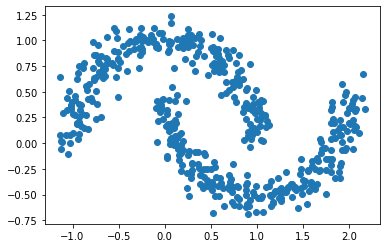

In [18]:
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
import pandas as pd

X, _ = make_moons(n_samples=500, noise=0.1)
plt.scatter(X[:,0], X[:,1])
plt.show()

In [19]:
X.shape

(500, 2)

Кластеризуйте это с помощью своей версии DBSCAN:

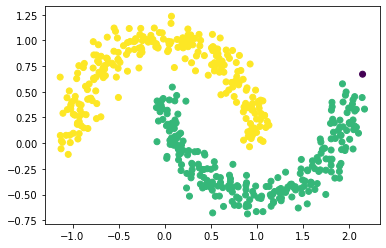

In [20]:
# your code here
clusters = dbscan(eps=0.2, min_samples=10).fit_predict(X)

plt.scatter(X[:,0], X[:,1], c=clusters)
plt.show()

Референс:

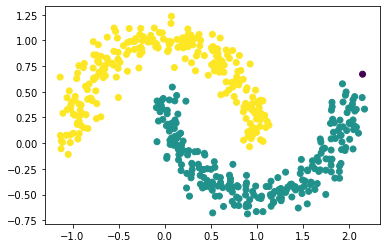

In [21]:
from sklearn.cluster import DBSCAN

clusters = DBSCAN(eps=0.2, min_samples=10).fit_predict(X)

plt.scatter(X[:,0], X[:,1], c=clusters)
plt.show()


> Получите 1 балл за ещё один интересный пример кластеризации (в качестве референса используйте предоставленное изображение. Нужно несколько интересных соседствующих форм):



C:\Users\nikita\AppData\Local\Temp/ipykernel_5712/442744003.py:17: MatplotlibDeprecationWarning: 
The set_offset_position function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  cs.set_offset_position('data')


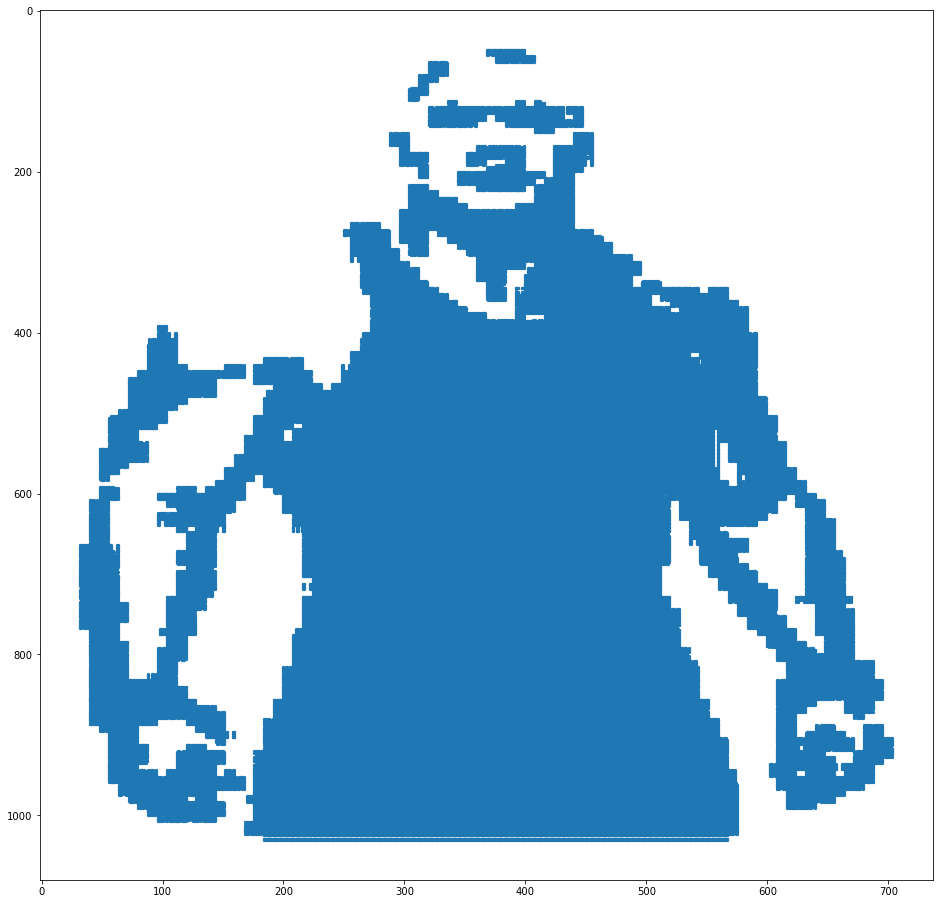

In [22]:
# your code here
import cv2
original = cv2.imread('rock.jpg')
resized_down = cv2.resize(original, (150,150), interpolation= cv2.INTER_LINEAR)

originalImage = cv2.cvtColor(original, cv2.COLOR_BGR2GRAY)
result = np.array(np.where(originalImage != 254))
listOfCoordinates = list(zip(result[0], result[1]))
x_val = [x[0] for x in listOfCoordinates]
y_val = [x[1] for x in listOfCoordinates]

plt.figure(figsize=(16, 16))
plt.scatter(y_val, x_val, s=5)
plt.gca().invert_yaxis()
ax = plt.gca()
cs = ax.collections[0]
cs.set_offset_position('data')
cs.get_offsets()
plt.show()

In [23]:
coord = np.ma.getdata(cs.get_offsets())

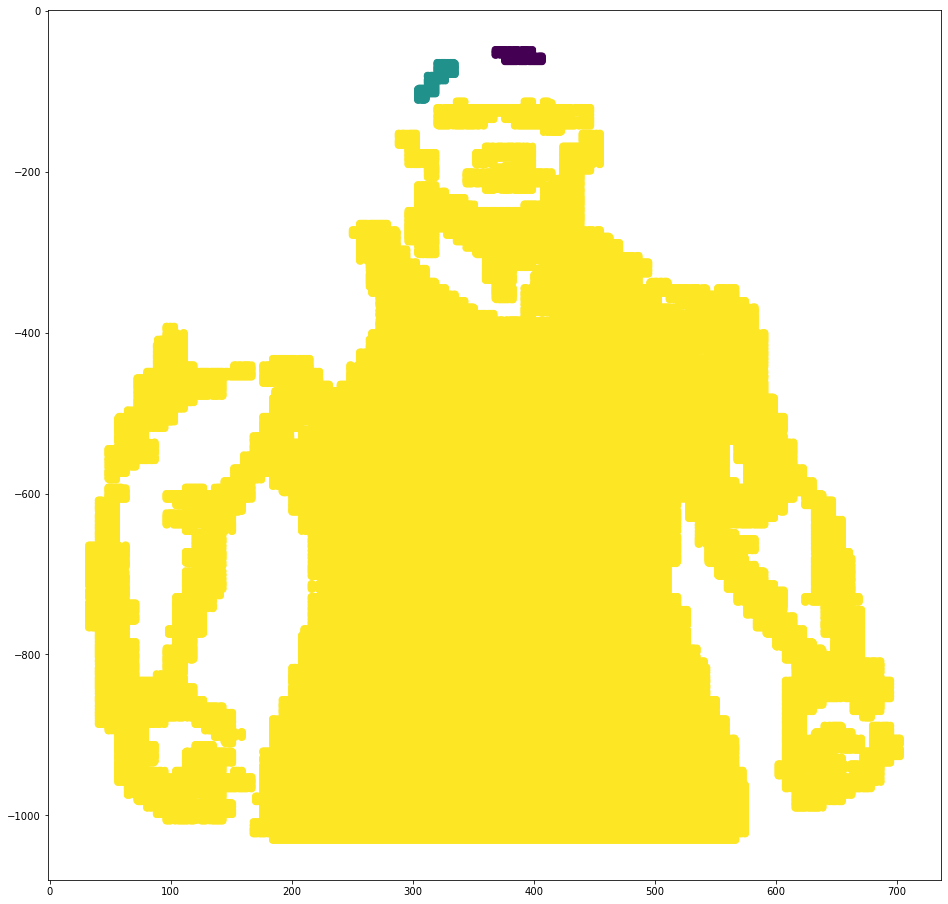

In [25]:
clusters = DBSCAN(eps=10, min_samples=10).fit_predict(coord)

plt.figure(figsize=(16, 16))
plt.scatter(coord[:,0], -1*coord[:,1], c=clusters)
plt.show()

Или хотя бы что-нибудь такое: 

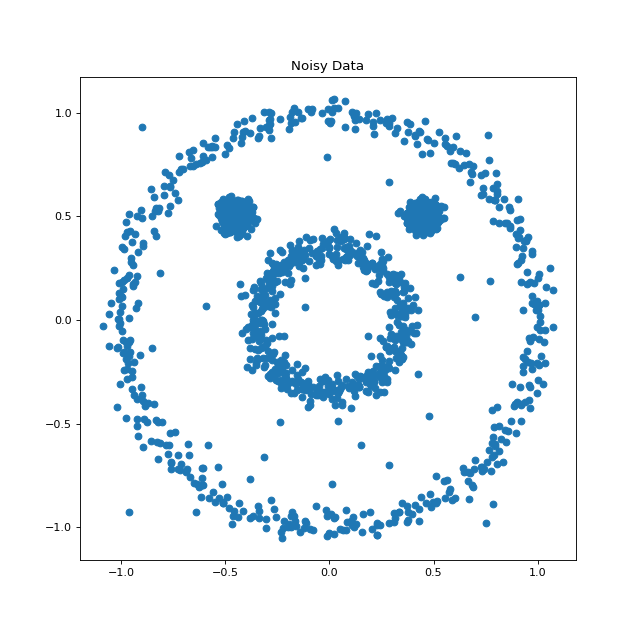


> Получите ещё 1 балл, если время работы вашего алгоритма больше референсного не более чем в 100 раз с учётом погрешности 3% от вашего времени:



In [26]:
%%time
%%capture
clusters = DBSCAN(eps=0.2, min_samples=10).fit_predict(X)

Wall time: 3.99 ms


In [27]:
%%time
%%capture
clusters = dbscan(eps=0.2, min_samples=10).fit_predict(X)

Wall time: 1.52 s


## Применяем DBSCAN (3 балла)

__[1.5 балла]__ Возьмите колонки `Distance` и `DepTime` (из датасета о задержках самолётов). Запустите на тренировочной выборке на них DBSCAN. Нарисуйте облоко рассеивания с получившимися кластерами. Насколько много их вышло? 

In [33]:
# your code here  ლ(ಠ益ಠლ)
X_train = train[['Distance', 'DepTime']].values
y_train = train['dep_delayed_15min'].map({'Y': 1, 'N': 0}).values
X_test = test[['Distance', 'DepTime']].values
X_train_part, X_valid, y_train_part, y_valid = train_test_split(X_train, y_train, test_size=0.3)

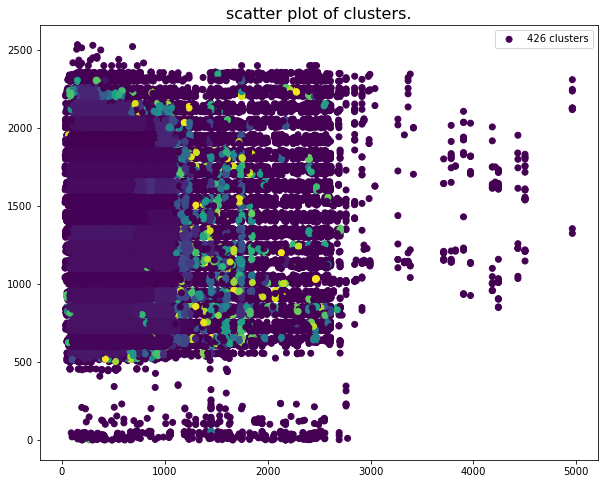

In [45]:
clusters = DBSCAN(eps=10, min_samples=10).fit_predict(X_train)

f, ax = plt.subplots(1,1, figsize=(10,8))
ax.scatter(X_train[:,0], X_train[:,1], c=clusters, label=f'{len(np.unique(clusters))} clusters')
ax.set_title('scatter plot of clusters.', fontsize=16)
ax.legend()
plt.show()

Попробуйте перебрать параметры `eps` и `min_samples` по решётке и нарисовать для каждой пары облако рассеивания. При каких параметрах шумовых точек оказывается больше всего? Почему так происходит? 

__Ответ:__ 

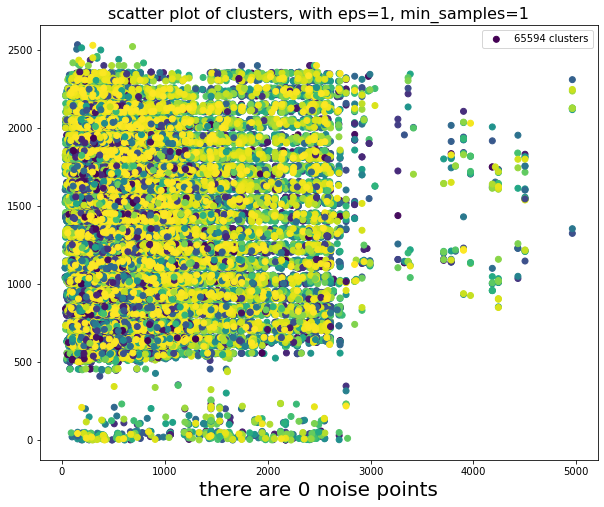

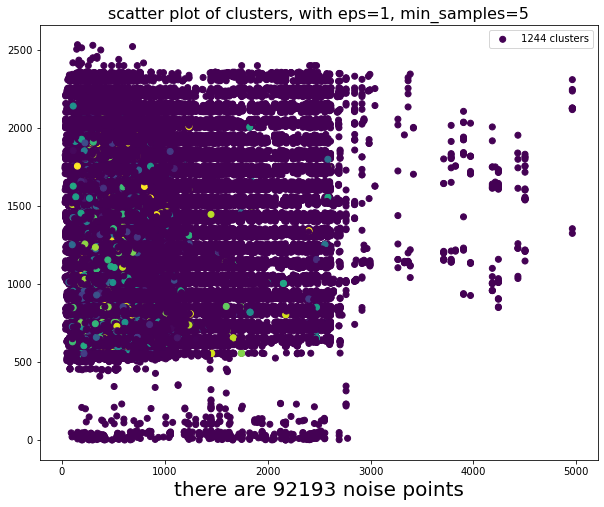

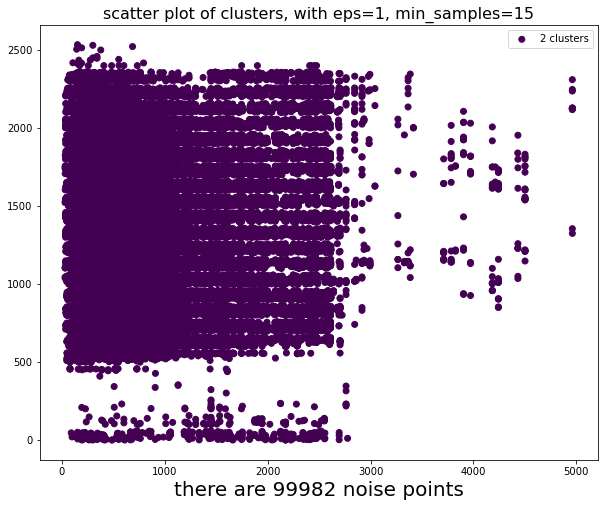

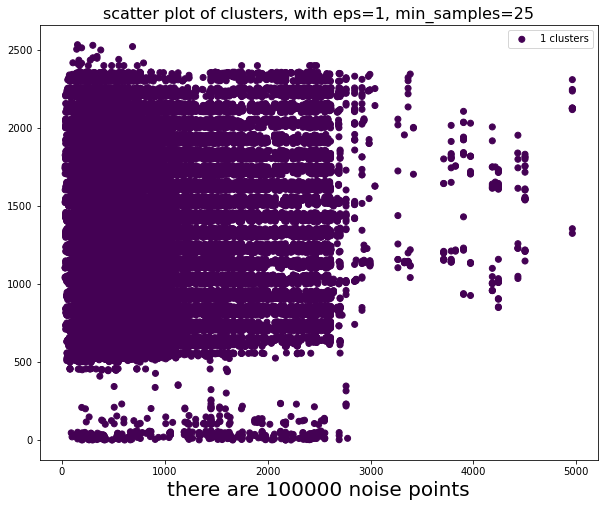

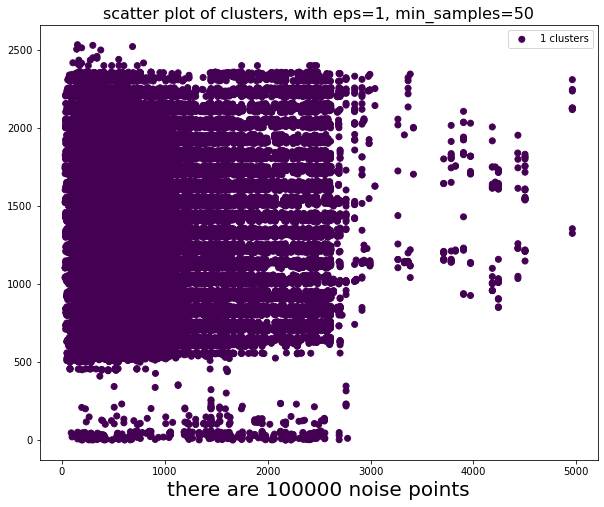

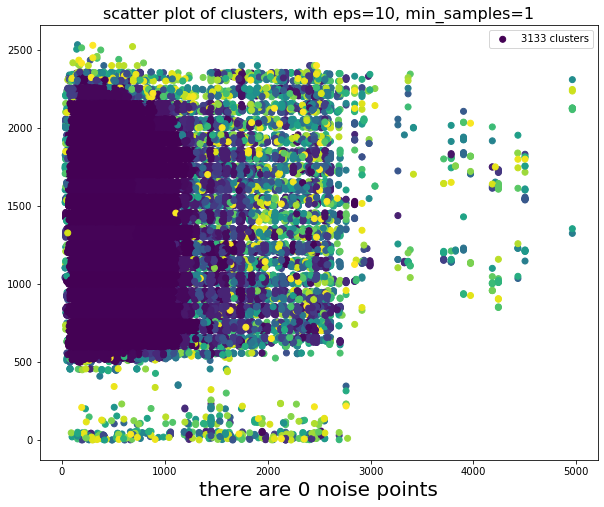

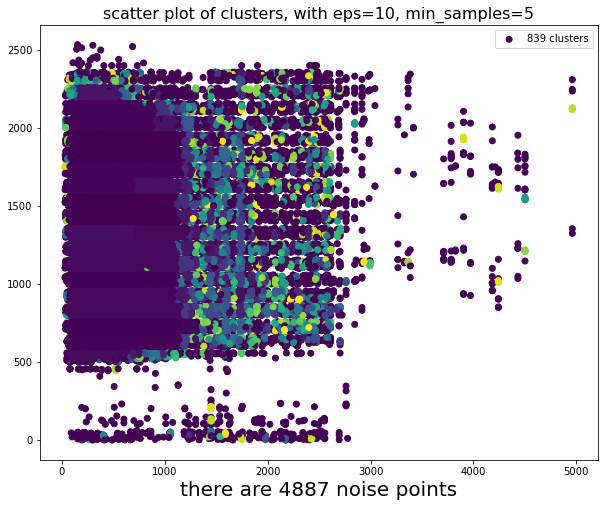

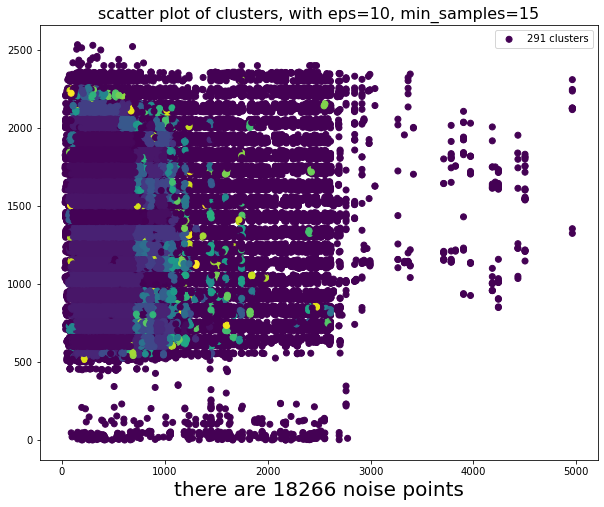

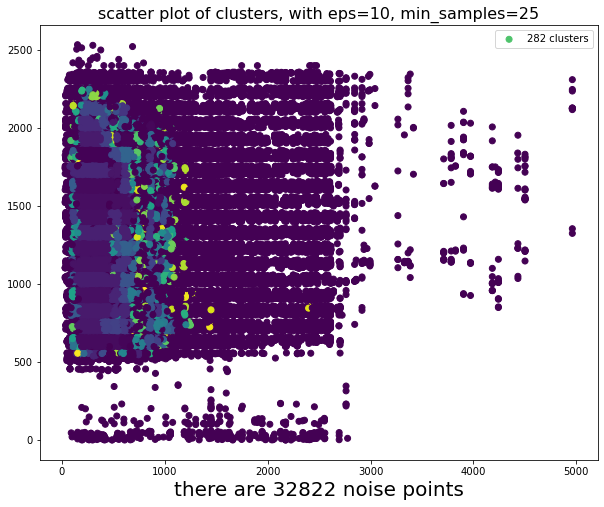

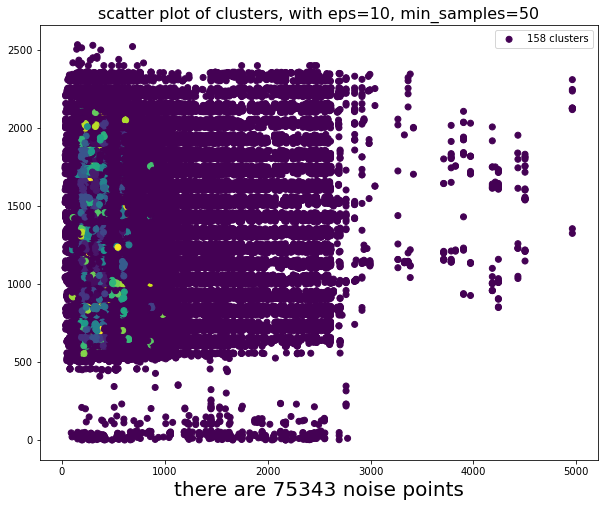

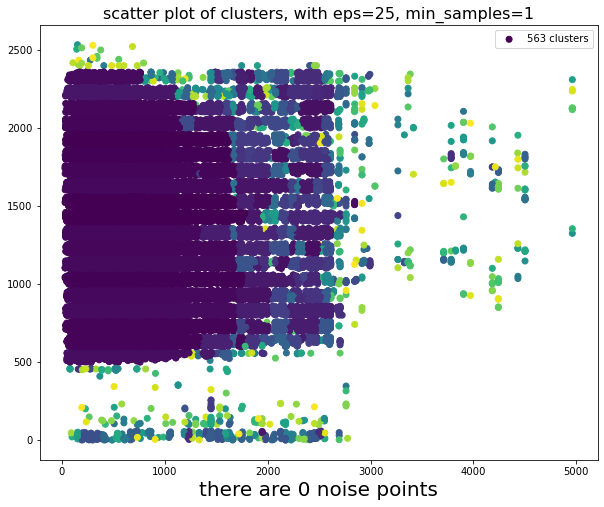

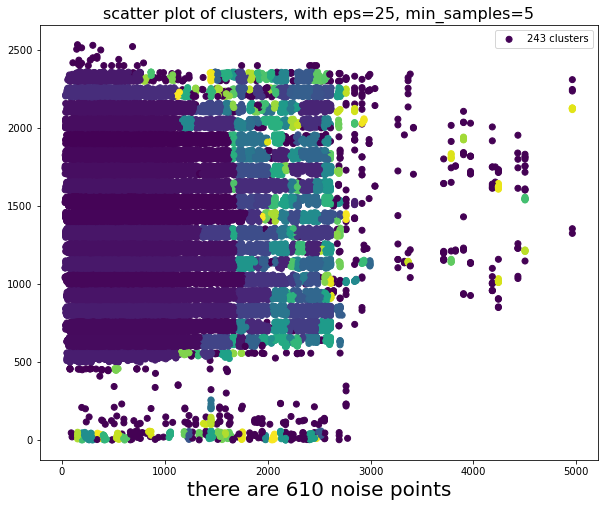

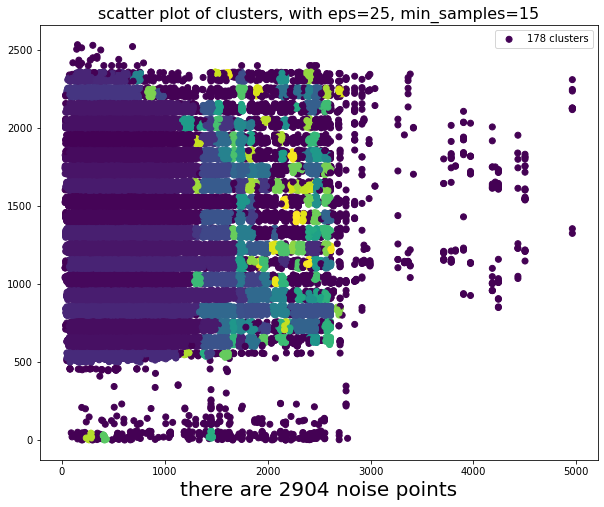

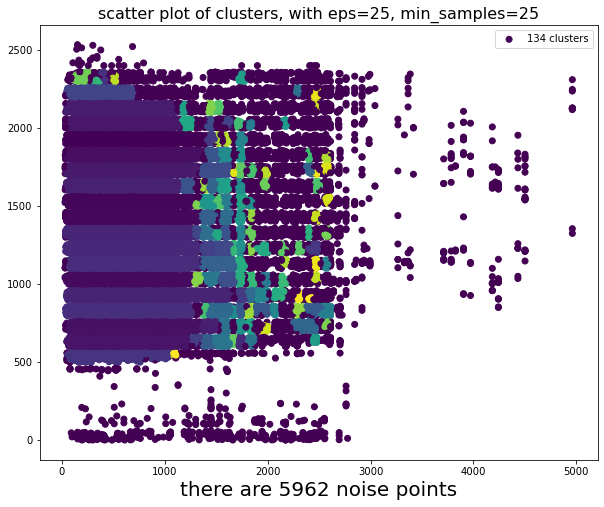

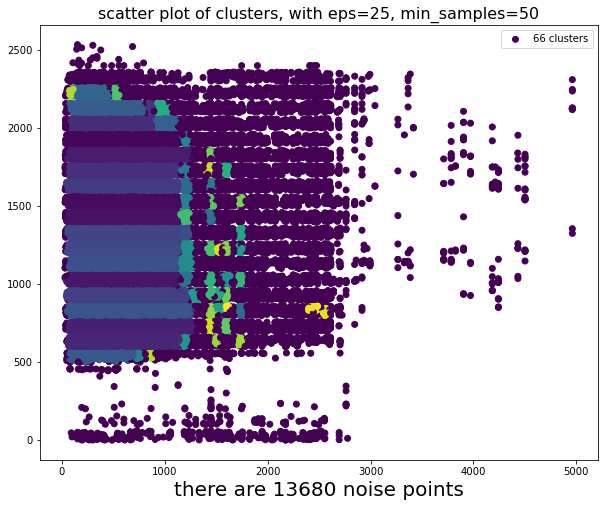

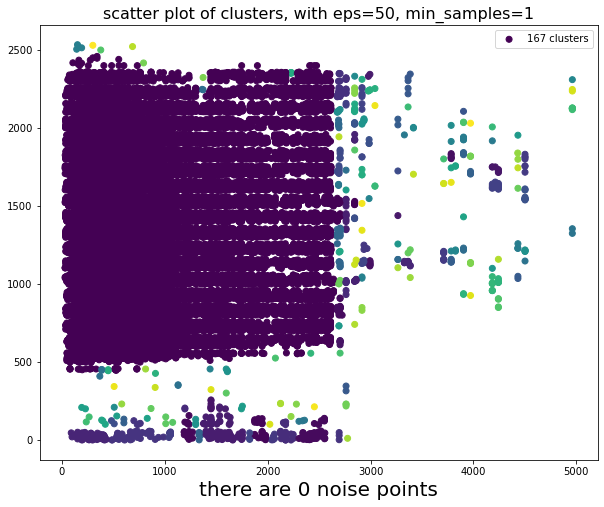

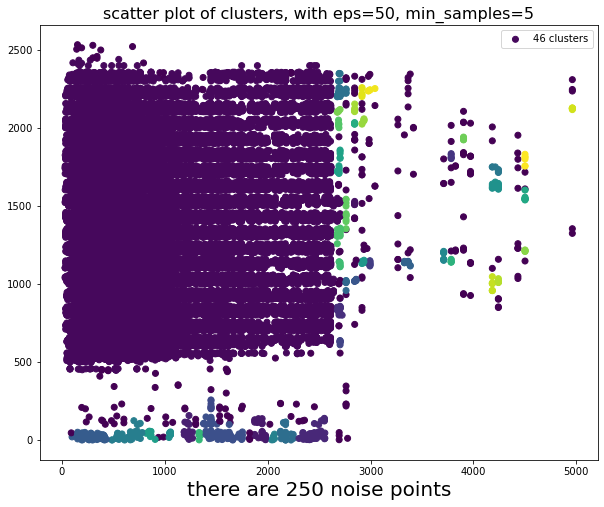

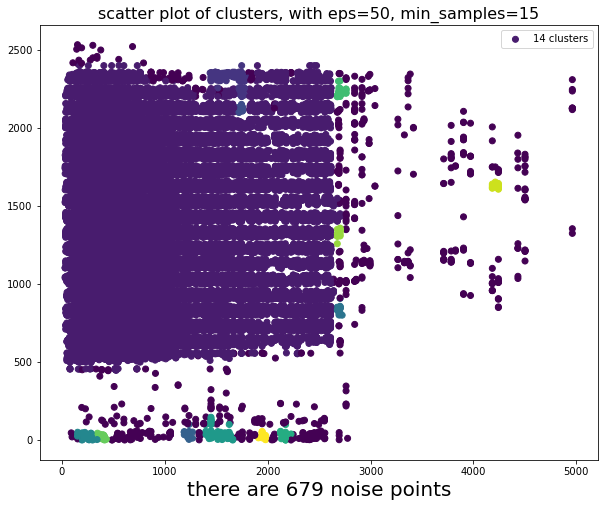

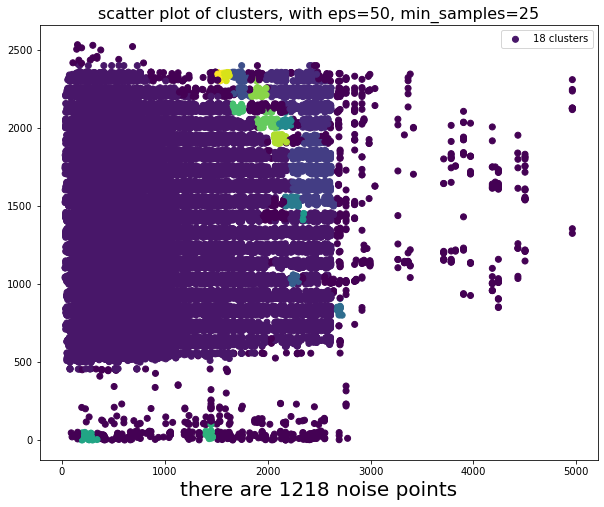

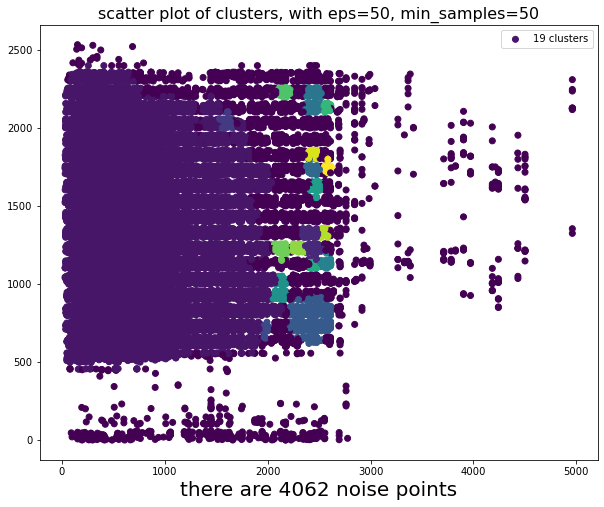

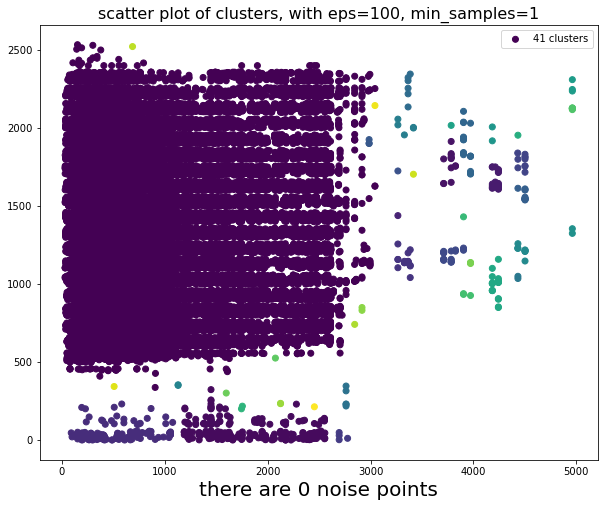

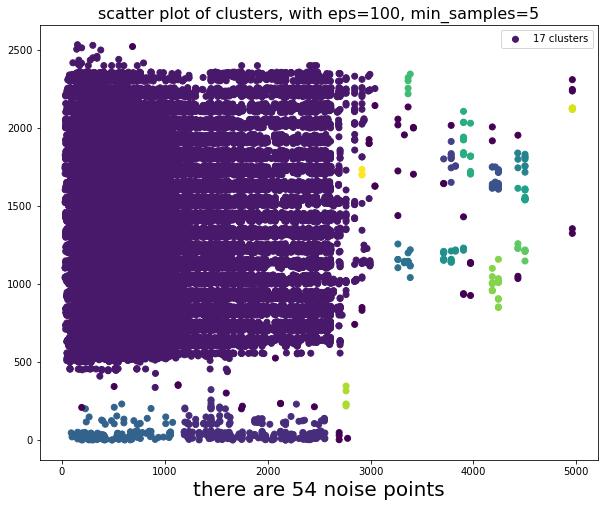

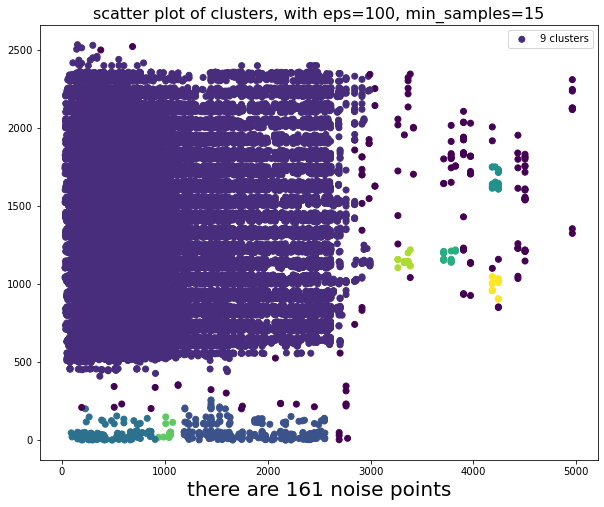

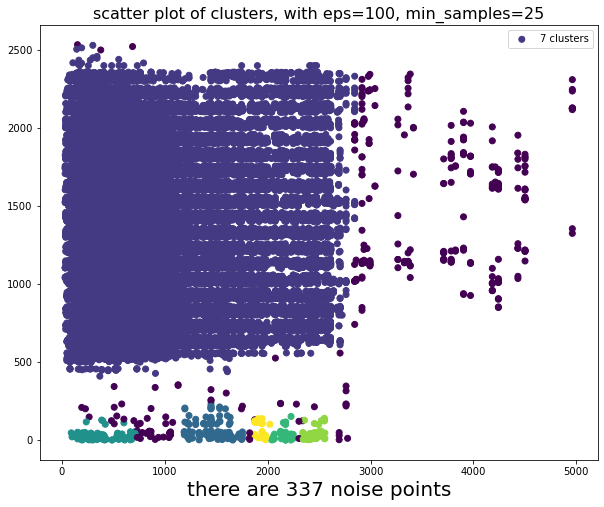

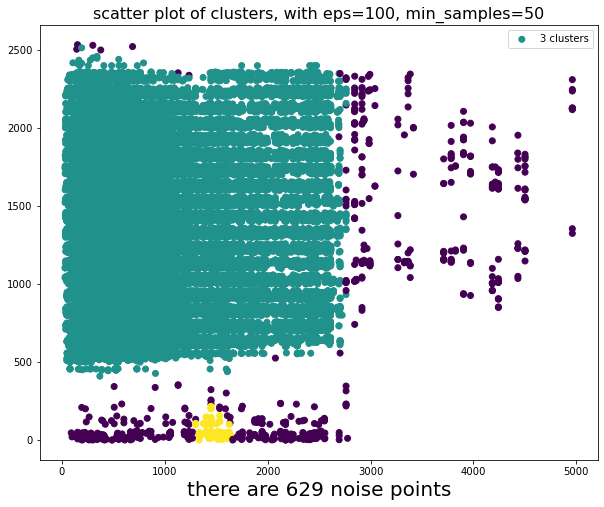

In [50]:
# your code here   ⟅⎛ꌩωꌩ⎞⟆
eps_array = [1, 10, 25, 50, 100]
min_samples_array = [1, 5, 15, 25, 50]

for eps in eps_array:
    for min_sample in min_samples_array:
        clusters = DBSCAN(eps=eps, min_samples=min_sample).fit_predict(X_train)
        noise_points = clusters.tolist().count(-1)
        f, ax = plt.subplots(1,1, figsize=(10,8))
        ax.scatter(X_train[:,0], X_train[:,1], c=clusters, label=f'{len(np.unique(clusters))} clusters')
        ax.set_title(f'scatter plot of clusters, with eps={eps}, min_samples={min_sample}', fontsize=16)
        ax.set_xlabel(f'there are {noise_points} noise points', fontsize=20)
        ax.legend()
        plt.show()

**Ответ**:
* При малом значение eps и значением min_samples начиная от 50, количество шумовых точек много, так как:
* Во-первых, окрестность охвата кластера маленькая, однако в эту маленькую окрестность нужно уместить соответсвующе кол-во точек, но при настолько низких значения гиперпараметра eps, любое превышение - шумовая точка.
* Во-вторых, min_samples отвечает за количественную составляющую кластера, соответственно мы треуем определенного кол-ва точек в окрестности кластера, что провоцирует появлентю шумовых точек.

__[1.5 балла]__ Добавьте в датасет новую категориальную переменную: номер кластера из DBSCAN и обучите Catboost со своими лучшими гиперпараметрами. Улучшилось ли качество модели на тестовой выборке? Как думаете, почему? 

In [54]:
# your code here  ¯\_(ツ)_/¯
clusters = DBSCAN(eps=50, min_samples=5).fit_predict(X_train)
train['number of cluster'] = clusters
train['number of cluster'].value_counts()

 0     99104
-1       250
 10       94
 12       64
 4        40
 18       37
 5        31
 16       31
 15       28
 2        26
 3        25
 31       22
 22       15
 25       13
 21       11
 33       11
 26       10
 13       10
 7         9
 23        8
 24        8
 20        8
 14        8
 9         8
 30        7
 40        7
 11        7
 17        7
 8         7
 29        7
 32        6
 39        6
 38        6
 37        6
 34        6
 44        6
 41        6
 6         5
 1         5
 35        5
 36        5
 28        5
 27        5
 43        5
 42        5
 19        5
Name: number of cluster, dtype: int64

In [65]:
X_train = train[['Distance', 'DepTime', 'DayofMonth', 'DayOfWeek', 'Month', 'UniqueCarrier', 'Origin', 'Dest','number of cluster']].values
y_train = train['dep_delayed_15min'].values

X_train_part, X_valid, y_train_part, y_valid = train_test_split(X_train, y_train, test_size=0.3, random_state=2002)

In [73]:
xgb_model = XGBClassifier(n_estimators=250, max_depth=6, learning_rate=0.324)
xgb_model.fit(X_train_part, y_train_part)
roc_auc_score(y_valid, xgb_model.predict_proba(X_valid)[:, 1])

0.7361986661754277

In [74]:
from catboost import CatBoostClassifier, CatBoostRegressor

cb = CatBoostClassifier(n_estimators=250, max_depth=6, learning_rate=0.324)
cb.fit(X_train_part, y_train_part)
roc_auc_score(y_valid, cb.predict_proba(X_valid)[:, 1])

0:	learn: 0.5474535	total: 23ms	remaining: 5.72s
1:	learn: 0.4952255	total: 29.8ms	remaining: 3.7s
2:	learn: 0.4698782	total: 36.4ms	remaining: 3s
3:	learn: 0.4579345	total: 42.7ms	remaining: 2.62s
4:	learn: 0.4527615	total: 49.4ms	remaining: 2.42s
5:	learn: 0.4478568	total: 56ms	remaining: 2.27s
6:	learn: 0.4456817	total: 61.9ms	remaining: 2.15s
7:	learn: 0.4430401	total: 68.3ms	remaining: 2.06s
8:	learn: 0.4420542	total: 74.5ms	remaining: 1.99s
9:	learn: 0.4405048	total: 80.8ms	remaining: 1.94s
10:	learn: 0.4398841	total: 87ms	remaining: 1.89s
11:	learn: 0.4390858	total: 93.6ms	remaining: 1.86s
12:	learn: 0.4383042	total: 100ms	remaining: 1.83s
13:	learn: 0.4377364	total: 107ms	remaining: 1.81s
14:	learn: 0.4370197	total: 114ms	remaining: 1.79s
15:	learn: 0.4363029	total: 121ms	remaining: 1.77s
16:	learn: 0.4354816	total: 128ms	remaining: 1.75s
17:	learn: 0.4346353	total: 134ms	remaining: 1.73s
18:	learn: 0.4339697	total: 139ms	remaining: 1.69s
19:	learn: 0.4334402	total: 146ms	remai

163:	learn: 0.3878467	total: 1.12s	remaining: 589ms
164:	learn: 0.3876177	total: 1.13s	remaining: 583ms
165:	learn: 0.3873701	total: 1.14s	remaining: 576ms
166:	learn: 0.3871322	total: 1.15s	remaining: 569ms
167:	learn: 0.3868225	total: 1.15s	remaining: 562ms
168:	learn: 0.3866620	total: 1.16s	remaining: 556ms
169:	learn: 0.3863539	total: 1.17s	remaining: 549ms
170:	learn: 0.3861449	total: 1.17s	remaining: 542ms
171:	learn: 0.3859102	total: 1.18s	remaining: 535ms
172:	learn: 0.3856686	total: 1.19s	remaining: 528ms
173:	learn: 0.3855473	total: 1.19s	remaining: 521ms
174:	learn: 0.3854243	total: 1.2s	remaining: 514ms
175:	learn: 0.3851573	total: 1.21s	remaining: 507ms
176:	learn: 0.3848988	total: 1.21s	remaining: 501ms
177:	learn: 0.3846523	total: 1.22s	remaining: 494ms
178:	learn: 0.3844450	total: 1.23s	remaining: 487ms
179:	learn: 0.3842131	total: 1.23s	remaining: 480ms
180:	learn: 0.3840371	total: 1.24s	remaining: 473ms
181:	learn: 0.3837948	total: 1.25s	remaining: 466ms
182:	learn: 0

0.7341253493053974

__Ответ:__

* Почему-то улучшению добиться особо не получилось, однако это может говорить о том, что номер кластера, не несет особой нагрузки для модели, а может даже и наоборот лишь мешает в предсказании правильного ответа.

# Небольшие подарочки

**+0.1 балла** за фотографию того, как вы проводите лето на открытом воздухе

![![image.png](attachment:image.png)](https://sun9-84.userapi.com/impf/Pyp4T5aVnQ1fiT3Se9yZDAKvGUfuAC6uadXqyQ/QHqlxbEgR0w.jpg?size=320x240&quality=96&keep_aspect_ratio=1&background=000000&sign=7153545da4eefb346d84b27940e60dac&type=video_thumb)

**+0.1 балла** за смешной мем по машинному обучению

![![image.png](attachment:image.png)](https://sun9-15.userapi.com/impf/c850224/v850224869/99bb5/g9tBK6tr1-0.jpg?size=500x629&quality=96&sign=85fb4468ce3cca770ca46c8c7d732f6f&type=album)

**+0.1 балла** за развернутый отзыв о курсе: ваших впечатлениях, сложностях и радостях, любимых темах и т.д.

* В общем курс оставил лишь положительное впечатление, как от самого процесса обучения, так и от общения с семинаристами, кураторами и конечно же лектором. 
* Сложно было наверно адаптироваться под графики сдачи дз, так как учеба по основной образовательной программе не стояла на месте, но в конце-концов все сложилось замечательно.
* Радость это наверно получение высоких оценок за твои знания и старания, ну и анекдоты от дяди Жени.
* Любимая тема наверное была "Деревья". С ней пришлось очень много повозиться, но результат сдачи и обретенные знания показали, что все это было не напрасно.